# Training a Neural Network
To train a neural network, we must perform following steps:
1. Import the relevant packages.
2. Build up a dataset that can fetch data one data point at a time.
3. Wrap the DataLoader from the dataset.
4. Build a model and then define a loss function and an optimizer.
5. Define two functions to train and validate data respectively.
6. Define a function that will calculate the accuracy of the data.
7. Perform weight updates based on each batch of data over increasing epochs.

Let's perform each step:

1. Import the relevant packages and the FMNIST dataset:

In [13]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import datasets

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

data_folder = "./data/FMNIST"
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

train_images = fmnist.data
train_labels = fmnist.targets

Device: cuda


2. Build a class that fetches a dataset. Remember that it is derived from `Dataset` class and needs three methods `__init__`, `__getitem__`, and `__len__` to **always** be defined:

In [4]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1, 28*28)
        self.x, self.y = x, y
    
    def __getitem__(self, idx):
        x, y = self.x[idx], self.y[idx]
        return x.to(device), y.to(device)
    
    def __len__(self):
        return len(self.x)

Note that int the `__init__` method, we have converted the input into *foating-point* number and have also flattened each image into 28*28=784 numeric values (where each numeric value corresponds to a pixel value). 

3. Create a function that generates a training DataLoader `train_dataloader` from the dataset `FMNISTDataset`, this will sample 32 data points at random for the batch size:

In [5]:
def get_data():
    train_dataset = FMNISTDataset(train_images, train_labels)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    return train_dataloader

4. Define a model, as well as the loss function and the optimizer:

In [6]:
from torch.optim import SGD
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_func = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_func, optimizer

The model is a network with one hidden layer containing 1000 neurons. The output is a 10-neuron layer since there are 10 possible classes. Furthermore, we are calling `CrossEntropyLoss` function since the output can belong to any of the 10 classes for each image.

**NOTE**
We are not using *softmax* in the neural network at all.
The range of outputs is unconstrained in that values can have an infinite range, whereas cross-entropy loss typically expects outputs as probabilites (each row should sum to 1).

This still works in this setting because `nn.CrossEntropyLoss` actually expects us to send the raw *logits* (that is, unconstrained values). It performs *softmax* internally.

5. Define a function that will train the dataset on a batch of images:

In [7]:
def train_batch(x, y, model, optimizer, loss_func):
    model.train()
    prediction = model(x)
    batch_loss = loss_func(prediction, y)
    
    # based on forward pass in model(x) compute all the gradients of model.parameters()
    batch_loss.backward()
    # apply new_weights = optimizer(old_weights, old_weights_gradients)
    optimizer.step()
    # Flush gradients memory for next batch of calculations
    optimizer.zero_grad()
    return batch_loss.item()

The preceeding code passses batch of images through the model in *forward pass*. 
Then computes loss on batch and the passes the weights through *backward propagation* and *updates* them.
Finnaly, it flushes the memory of the gradient so that it doesn't influence how the gradient is calculated in the next pass.

Now that we've done this, we extract the loss value as a scalar by fetching `batch_loss.item()`

6. Build a function that calculates the accuracy of a given dataset:

In [8]:
# There's no need to update weights when calculating accuracy
# so there's no need to calculate gradients
# decorating function (like below) will do that
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In the preceeding code we use `@torch.no_grad()` to explicitly tell that we won't compute gradients,
and then we calculate `prediction` by feed-forwarding input through model.

Next, we invoke `prediction.max(-1)` to identify the argmax index corresponding to each row.

Next, we are comparing our `argmaxes` with ground truth using `argmaxes == y` so that we can check whether each row is predicted correctly.

7. Train neural network:

In [9]:
total_epochs = 5

train_dataloader = get_data()
model, loss_func, optimizer = get_model()
losses, accuracies = [], []

for epoch in range(total_epochs):
    print(f"epoch {epoch}")
    epoch_losses, epoch_accuracies = [], []
    
    for idx, batch in enumerate(iter(train_dataloader)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_func)
        epoch_losses.append(batch_loss)
    
    epoch_loss = np.array(epoch_losses).mean()
    
    for idx, batch in enumerate(iter(train_dataloader)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    
    epoch_accuracy = np.mean(epoch_accuracies)
    
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)
       

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4


C:\Users\Adam\AppData\Local\Temp\ipykernel_17572\3222874133.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


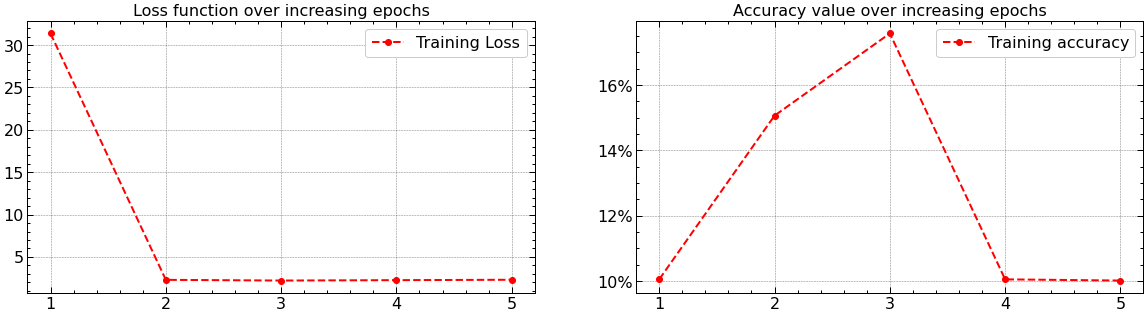

In [23]:
# Display variation of training loss and accuracy over increasing epochs
plt.style.use(['science', 'notebook', 'grid'])
epochs = np.arange(total_epochs)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title("Loss function over increasing epochs")
plt.plot(epochs, losses, "ro--", label="Training Loss")
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
plt.legend()
plt.subplot(122)
plt.title("Accuracy value over increasing epochs")
plt.plot(epochs, accuracies, "ro--", label="Training accuracy")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
plt.legend()